In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# The push-forward of a distribution

(DRAFT- might lack some technical details)

Let $f:X \to Y$ be an invertible function and $P$ be a probability distribution on $X$.
Then the push-forward $f_*P$ of $P$ under $f$ is defined as 

$$
    f_*P := P \circ f^{-1}.
$$

Here $f^{-1}$ denotes the preimage. Its density $q$ is given by

$$
    q(y) = \frac{d(P \circ f^{-1})}{dy}(y)  =  \ldots =p(x) \cdot \frac{1}{|\det df_x|}.
$$

A sample $x \sim P$ defines a sample $y = f(x) \sim (f_*P)$.

Thus we need to provide $p, f, f^{-1}$, and $\det df_x$ to implement a corresponding pushforward object. 

In [2]:
#nbx --fname GenPushForward.jl --src src
module GenPushForward
using Gen
using Zygote


struct OutOfDomain end
const out_of_domain = OutOfDomain()
in_domain(f::Function) = x -> f(x) != out_of_domain
in_domain(f::Function, xs) = filter( x -> f(x) != out_of_domain, xs)


"""
    PushForward
    
The push-forward of a distribution ...
"""
struct PushForward{T,T′} <: Gen.Distribution{T} 
    dist :: Gen.Distribution{T}
    f       :: Function
    finv    :: Function
    detdf   :: Union{Function, Nothing}
    return_type :: Type{T′} # Return type of `f`, don't think we need that really ...
end

function Gen.random(Q::PushForward, args...) Q.f(random(Q.dist, args...))
end
(Q::PushForward)(args...) = random(Q, args...)
function Gen.logpdf(Q::PushForward{T,T′}, y::T′, args...) where {T, T′}
    x = Q.finv(y)
        
    # We only require `f` to be invertible over its image, i.e.
    # its inverse might not be defined everywhere...
    if x == OutOfDomain() return -Inf; end
        
    log_p = logpdf(Q.dist, x, args...)
        
    # Check if f is a mapping between discrete spaces
    # so there is no `df`, if not add the appropriate 
    # correction term
    if Q.detdf == nothing
            return log_p
    else
            return log_p - log(abs(Q.detdf(x)))
    end
end

function Gen.logpdf_grad(d::PushForward{T,T′}, v::T′, args...) where {T, T′} 
        Zygote.gradient((v, args...) -> logpdf(d, v, args...), v, args...)
end

# `Q` has same arguments as its underlying distribution `dist` and
# `f` is assumed to be differentiable, so we can set ...
Gen.has_argument_grads(Q::PushForward) = Gen.has_argument_grads(Q.dist) 
Gen.has_output_grad(   Q::PushForward) = Gen.has_output_grad(Q.dist) 

function invert(d::Dict)
    inv = Dict()
    for (k,v) in d; inv[v] = k; end
    return inv
end

function get_value_type(d::Dict)
    types = map(typeof, values(d))
    return length(types) == 1 ? types[1] : Union{types...}
end
    
function PushForward(dist::Gen.Distribution{T}, f::Dict, return_type::Type{T′}) where {T,T′}
    finv = invert(f)
    return PushForward{T,T′}(dist, x -> f[x], y -> finv[y], nothing, return_type)
end
     
function PushForward(dist::Gen.Distribution{T}, f::Dict) where {T}
    return PushForward(dist, f, get_value_type(f))
end
        
# Not sure how I feel about this but oh well ...
Base.:*(f::Dict, dist::Gen.Distribution{T}) where {T} = PushForward(dist, f)
    
export PushForward, OutOfDomain, out_of_domain, in_domain
end # module

Main.GenPushForward

# Examples


In [3]:
using .GenPushForward
using Gen
using BenchmarkTools
using StatsBase, Plots
using LinearAlgebra: normalize, normalize!
col = palette(:tab10);

## Example 1

Let's consider the pushforward of 

$$
    p(x) = N(x ; \mu=0,\sigma=2)
$$

under 

$$
    f(x) = \tfrac{x}{10}.
$$

As a reality check let's integrate the pdf of the push-forward. We also compare the computed density and the "sample density", and benchmark the runtime.

approx. integral q = 0.9999999999999999
approx. integral p = 1.0


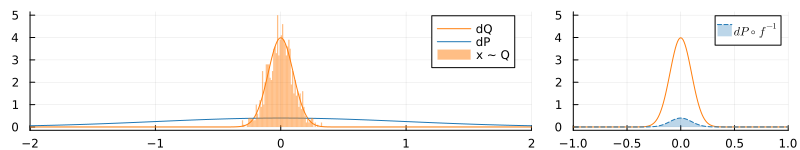

In [21]:
P = normal
f =  x -> x/10.0
g =  x -> x*10.0
detdf = x -> 1/10.0
Q = PushForward(P, f, g, detdf, Float64)
q = x -> exp(logpdf(Q, x, args...))
p = x -> exp(logpdf(P, x, args...))
args = (0.0, 1.)

dx = 0.01
xs = -10:dx:10
ys = q.(xs)
zs = p.(xs)
n = 1_000
qs = [Q(args...) for t=1:n]


xs_in_domain = in_domain(g, xs)
# --------------------------------------------
println("approx. integral q = $(sum(dx.*ys))")
println("approx. integral p = $(sum(dx.*zs))")
        
p1 = plot(xlim=(-2,2))      
plot!(xs, ys, label="dQ", color=col[2])
plot!(xs, zs, label="dP", color=col[1])
histogram!(qs, weights=ones(n)/n/dx, bins=-2:dx:2, color=col[2], label="x ~ Q",
           alpha=.5, markerstrokecolor=:red, linewidth=0., linecolor=:white)


p2 = plot( xlim=(-1,1))     
plot!(xs, ys, color=col[2], label=nothing)
plot!(xs_in_domain, [p(g(x)) for x in xs_in_domain], color=col[1], 
        fillrange=0,
        fillalpha=0.3, 
        linestyle=:dash,  label="\$dP \\circ f^{-1}\$")

l = grid(1, 2,  
    widths  = [0.7,0.3])
plot(p1, p2, layout = l, link=:y, size=(800,150))


We can now use `Q` like any other Gen distribution

In [22]:
@gen function gen_func()
    y ~ Q(args...)
end

tr = simulate(gen_func, ())
get_choices(tr)

│
└── :y : 0.01820867422644052


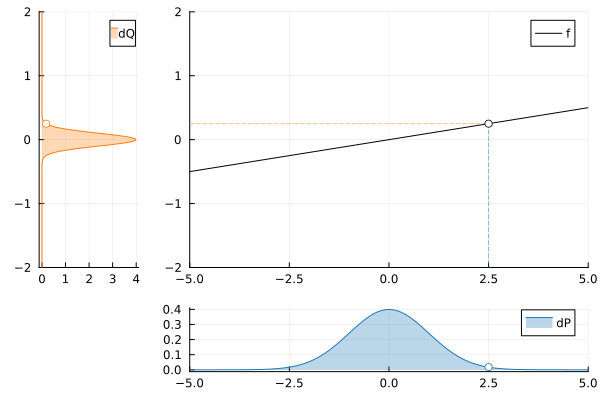

In [25]:
# --------------------------------------------
p1 = plot(ys, xs, label="dQ", fillrange=0, fillalpha=0.3, color=col[2], ylim=(-2,2))
scatter!([q(0.25)],[0.25], color=:white, label=nothing, markerstrokecolor=col[2])
p2 = plot(xs, [f(x) for x in xs], label="f", color="black", xlim=(-5,5), ylim=(-2,2))
plot!([-5, g(0.25)], [0.25, 0.25],  color=col[2], label=nothing, linestyle=:dash, alpha=.5)
plot!([g(0.25), g(0.25)], [0.25, -5],  color=col[1], label=nothing, linestyle=:dash, alpha=0.5)
scatter!([g(0.25)],[0.25], color=:white, label=nothing)
p3 = plot(xs, zs, label="dP", fillrange=0, fillalpha=0.3, color=col[1], xlim=(-5,5))
scatter!([g(0.25)],[p(g(0.25))], color=:white, label=nothing, markerstrokecolor=col[1])
l = grid(2, 2, 
    heights = [0.8,0.2], 
    widths  = [0.2,0.8])
plot(p1, p2, plot(foreground_color_subplot=:white), p3, layout = l)


In [26]:
# -------------------------
println("x ~ P vs. y ~ Q\n")
@btime $P($args...)
@btime $Q($args...)
println("\np(x) vs. q(y)\n")
@btime $p(1.0)
@btime $q(1.0)

x ~ P vs. y ~ Q

  5.889 ns (0 allocations: 0 bytes)
  49.190 ns (4 allocations: 64 bytes)

p(x) vs. q(y)

  260.399 ns (7 allocations: 112 bytes)
  460.853 ns (15 allocations: 320 bytes)


7.694598626706391e-22

## Example 2

Let's consider the pushforward of 
$$
    p(x) = N(x ; \mu=0,\sigma=2)
$$
under 
$$
    f(x) = \exp(x).
$$
Note that $f$ is not one-to-one but still invertible over its image. We can 
still use our pushforward object by incorporating `OutOfDomain()` values (or `out_of_domain`) in the inverse of $f$.

approx. integral q = 0.9893629854408353
approx. integral p = 1.0


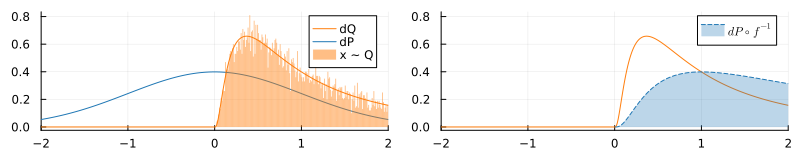

"/Users/mirko/Workspace/prob-comp/Gen-push-forward/imgs/push-forward_1.png"

In [31]:
# The distribution we want to push forward...
P = normal
args = (0.0, 1.)

# ...and the function to push forward with.
# Note that `f` is only invertible over its image.
f     =  x -> exp(x)
detdf =  x -> exp(x)
g     =  y -> y > 0 ? log(y) : out_of_domain;

# The push-forward
Q = PushForward(P, f, g, detdf, Float64)

# The densities
q = x -> exp(logpdf(Q, x, args...))
p = x -> exp(logpdf(P, x, args...))

dx = 0.01
xs = -10:dx:10
ys = [q(x) for x in xs]
zs = [p(x) for x in xs]
n = 10_000
qs = [Q(args...) for t=1:n]
ps = [P(args...) for t=1:n]

xs_in_domain = in_domain(g, xs)
# --------------------------------------------
println("approx. integral q = $(sum(dx.*ys))")
println("approx. integral p = $(sum(dx.*zs))")
        
p1 = plot(xlim=(-2,2))      
plot!(xs, ys, label="dQ", color=col[2])
plot!(xs, zs, label="dP", color=col[1])
histogram!(qs, weights=ones(n)/n/dx, bins=0:dx:2, color=col[2], label="x ~ Q",
           alpha=.5, markerstrokecolor=:red, linewidth=0., linecolor=:white)

p2 = plot( xlim=(-2,2))     
plot!(xs, ys, color=col[2], label=nothing)
plot!(xs_in_domain, [p(g(x)) for x in xs_in_domain], color=col[1], 
        fillrange=0,
        fillalpha=0.3, 
        linestyle=:dash,  label="\$dP \\circ f^{-1}\$")

l = grid(1, 2,  
    widths  = [0.5,0.5])
myplot = plot(p1, p2, layout = l, link=:y, size=(800,150))
display(myplot)
savefig(myplot,"imgs/push-forward_1.png")

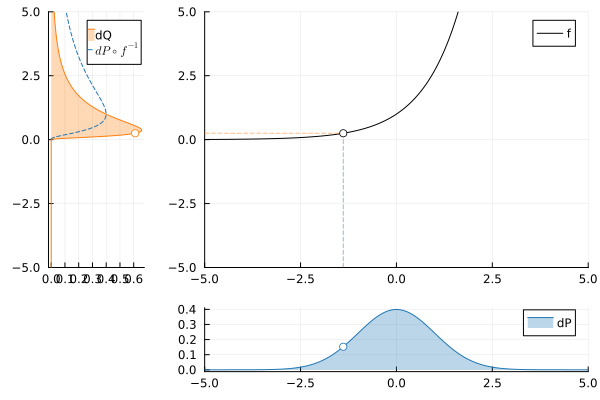

"/Users/mirko/Workspace/prob-comp/Gen-push-forward/imgs/push-forward_2.png"

In [32]:
# --------------------------------------------
p1 = plot(ys, xs, label="dQ", fillrange=0, fillalpha=0.3, color=col[2], ylim=(-5,5))
plot!([p(g(x)) for x in xs_in_domain],xs_in_domain, color=col[1], 
#         fillrange=0,
#         fillalpha=0.3, 
        linestyle=:dash,  label="\$dP \\circ f^{-1}\$")
scatter!([q(0.25)],[0.25], color=:white, label=nothing, markerstrokecolor=col[2])
p2 = plot(xs, [f(x) for x in xs], label="f", color="black", xlim=(-5,5), ylim=(-5,5))
plot!([-5, g(0.25)], [0.25, 0.25],  color=col[2], label=nothing, linestyle=:dash, alpha=.5)
plot!([g(0.25), g(0.25)], [0.25, -5],  color=col[1], label=nothing, linestyle=:dash, alpha=0.5)
scatter!([g(0.25)],[0.25], color=:white, label=nothing)
p3 = plot(xs, zs, label="dP", fillrange=0, fillalpha=0.3, color=col[1], xlim=(-5,5))
scatter!([g(0.25)],[p(g(0.25))], color=:white, label=nothing, markerstrokecolor=col[1])
l = grid(2, 2, 
    heights = [0.8,0.2], 
    widths  = [0.2,0.8])
myplot = plot(p1, p2, plot(foreground_color_subplot=:white), p3, layout = l)
display(myplot)
savefig(myplot,"imgs/push-forward_2.png")

In [33]:
# -------------------------
println("x ~ P vs. y ~ Q\n")
@btime $P($args...)
@btime $Q($args...)
println("\np(x) vs. q(y)\n")
@btime $p(1.0)
@btime $q(1.0)

x ~ P vs. y ~ Q

  6.719 ns (0 allocations: 0 bytes)
  49.247 ns (4 allocations: 64 bytes)

p(x) vs. q(y)

  257.230 ns (7 allocations: 112 bytes)
  468.716 ns (16 allocations: 336 bytes)


0.3989422804014327

## Example 3


Let's consider the pushforward of 

$$
    p(x) = \text{bernoulli}(0.75)
$$

under 

$$
     1 \mapsto x, 0 \mapsto y
$$

**Remark:** 
Note that for this example we could have used the `@dist` [DSL](https://www.gen.dev/docs/stable/ref/distributions/#dist_dsl-1). We are going to include that for the benchmarking below

In [34]:
@dist function Q_DSL(p, lookup)
    x = bernoulli(p)
    lookup[x]
end

Gen.CompiledDistWithArgs{Any}(Gen.WithLabelArg{Any, Bool}(Gen.Bernoulli()), 2, Bool[1, 0], (Gen.SimpleArg{Any}(2), Gen.SimpleArg{Any}(1)))

In [35]:
# Original and pushed forward versions of the distributions
# We are benchmarking discrete distributions here.
f = Dict(true => :x, false => "y");
args = (0.75,);

P = bernoulli;
Q = f*P; # Syntactic sugar for `PushForward(P, f)`

# The logpdfs of the above distributions
p     = x -> logpdf(P, true, args...)
q     = x -> logpdf(Q, :x, args...)
q_DSL = x -> logpdf(Q_DSL, :x, args..., f)

Q_samples = [Q(args...) for t=1:100]
# ------------------------
println(exp(logpdf(Q, :x, args...)))
println(sum(Q_samples .== :x)/length(Q_samples))

0.75
0.67


In [36]:
# -------------------------
println("Sampling time: x ~ P vs. y ~ Q vs. y ~ Q_DSL\n")
@btime $P($args...);
@btime $Q($args...);
@btime $Q_DSL($args..., f);
println("\nEvaluation time: p(x) vs. q(y) vs. q_DSL(y)\n")
@btime $p(true);
@btime $q(:x);
@btime $q_DSL(:x);

Sampling time: x ~ P vs. y ~ Q vs. y ~ Q_DSL

  4.165 ns (0 allocations: 0 bytes)
  35.726 ns (1 allocation: 16 bytes)
  588.171 ns (17 allocations: 544 bytes)

Evaluation time: p(x) vs. q(y) vs. q_DSL(y)

  151.724 ns (3 allocations: 48 bytes)
  220.906 ns (5 allocations: 160 bytes)
  943.200 ns (21 allocations: 768 bytes)
